In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import TipSlicer
import cv2
import scipy.ndimage as im
import tables
from importlib import reload
import os
import Object

In [3]:
x=arange(-1000,1000,1)
y=arange(-1000,1000,1)
X,Y=np.meshgrid(x,y)
print(X.shape)

(2000, 2000)


In [4]:
def myFigure(X,Y,z,extras):
    D=np.sqrt(X**2+Y**2)
    Xp=(2-cos(D/1000*0.3*np.pi))*X
    Yp=(2-cos(D/1000*0.3*np.pi))*Y
    period=50
    cut=12
    z2=2*z
    T1=TipSlicer.hexagonalSlice(Xp,Yp,z2,[20,period,-cut])
    
    Tc=T1.copy()
    Tc=np.where(X<-1000,0,Tc)
    Tc=np.where(X>1000,0,Tc)
    Tc=np.where(Y<-1000,0,Tc)
    Tc=np.where(Y>1000,0,Tc)
    
    border=3
    Tc[0:border]=0
    Tc[-border:]=0
    Tc[:,0:border]=0
    Tc[:,-border:]=0
    return Tc

In [5]:
ind=0

In [6]:
T=myFigure(X,Y,ind,0)
clf()
imshow(T)
title('Index {}'.format(ind))
ind=ind+1

In [7]:
Tc=im.binary_closing(T,iterations=10)
imshow(Tc)

In [23]:
%%%time
freePs,freeLabPos,freeLabs=TipSlicer.getOptimalFreestandingStitchCentres(T,150,150,X,Y,10)
print(len(freePs))

Something wrong with voting, will not close image
Something wrong with voting, will not close image
Something wrong with voting, will not close image
125
CPU times: user 3min, sys: 22.5 s, total: 3min 23s
Wall time: 3min 22s


In [21]:
amLabs2=[len(freeLab) for freeLab in freeLabs]

In [22]:
clf()
#plot(amLabs,'o')
plot(amLabs2,'x')
grid()

In [119]:
freePs=TipSlicer.getHexStitchCentres(T,150,X,Y)
print(len(hexPos))

76


In [120]:
freePs=TipSlicer.getSquareStitchCentres(T,150/np.sqrt(2),X,Y)
print(len(sqPos))

100


In [125]:
%%%time
# now find optimal solution with CONCORDE and CPLEX
TipSlicer.writeTSPfile('blocks.tsp',freePs)
!concorde -o 'tsp.sol' 'blocks.tsp'
Ord=TipSlicer.readTSPfile('tsp.sol')


concorde -o tsp.sol blocks.tsp
Host: ulb-UNLOCK-INSTALL  Current process id: 9926
Using random seed 1505131356
Problem Name: blocks
Problem Type: TSP
Nanoscribe Blocks in Ham Path
Number of Nodes: 126
Explicit Lengths (CC_MATRIXNORM)
Set initial upperbound to 26148 (from tour)
  LP Value  1: 26026.000000  (0.00 seconds)
  LP Value  2: 26131.500000  (0.01 seconds)
  LP Value  3: 26141.153846  (0.02 seconds)
  LP Value  4: 26148.000000  (0.03 seconds)
New lower bound: 26148.000000
Final lower bound 26148.000000, upper bound 26148.000000
Exact lower bound: 26148.000000
DIFF: 0.000000
Final LP has 159 rows, 239 columns, 990 nonzeros
Optimal Solution: 26148.00
Number of bbnodes: 1
Total Running Time: 0.17 (seconds)
CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 307 ms


In [106]:
clf()
plot(freePs[Ord][:,0],freePs[Ord][:,1],'.-')

In [ ]:
# If you do not have concorde, try the nearest neighbour ordering
Ord,NNd=TipSlicer.TSPnearest(freePs)

In [108]:
#%%%time
# STEP 5: Write out stacks
FovZ=45
Fov=300
hatching=0.5
slicing=3

amShells=2
ScaffStep=2 # for solid infill => 2*hatching is spacing here
hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False
#CodeSpeeds=np.ones(3)*30000
#CodeIntensities=np.ones(3)*80


am=np.int(np.round(Fov/hatching))
#amY=np.int(np.round(FovY/hatching))
zz=np.arange(0,FovZ,slicing)


dirName='MicroLensArray'
if (not os.path.exists(dirName)):
    os.mkdir(dirName)
genBlockName=dirName+'/'+dirName+'Block-{:05d}.h5'
genGwlName=dirName+'/'+dirName+'Block-{:05d}.gwl'
genRegex=dirName+'/.+gwl'
fullGwlName=dirName+'.gwl'

#sliceIndList=np.arange(0,FovZ+slicing,slicing)

#print(len(sliceIndList))
#print(sliceIndList)
#print(zz[sliceIndList])

fullDist=[]
allBlocks=[]
for i in np.arange(0,len(Ord)):
#for i in np.arange(0,10):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    xc=freePs[Ord][i,0]
    yc=freePs[Ord][i,1]

    xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
    yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
    Xloc,Yloc=np.meshgrid(xx,yy)
    
    # make the writing mask
    seeds=TipSlicer.convertToPixels(Xloc,Yloc,freeLabPos[Ord[i]])
    Tloc=myFigure(Xloc,Yloc,0,0)
    MM=TipSlicer.makeFreeMaterialMatrix(Tloc,seeds)
    
#    MM=FormulaSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
    
    
    # with these coordinate systems, apply formulaToStack
    blockName=genBlockName.format(i)
    
    FormulaSlicer.formulaToStack(blockName,Xloc,Yloc,zz,myFigure,extraParams=0,writingMask=MM)
    allBlocks.append(blockName)
    # and write the GWL's
    #print(sliceIndList)
    dists=TipSlicer.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep
                                   ,atAngles=-1,writeHeader=False,writeColourH5=False,doTopBottom=True)
    if (len(dists)>0):
        if (len(fullDist)==0):
            fullDist=dists
        else:
            fullDist=fullDist+dists

    
TipSlicer.writeGwlForRegex(fullGwlName,genRegex)

#writeTime=(fullDist/CodeSpeeds[:len(fullDist)]).sum()/3600.
#print('Printing will take +- {:.2f} hours'.format(writeTime))

Writing block 0
Writing block 1
Writing block 2
Writing block 3
Writing block 4
Writing block 5
Writing block 6
Writing block 7
Writing block 8
Writing block 9
Writing block 10
Writing block 11
Writing block 12
Writing block 13
Writing block 14
Writing block 15
Writing block 16
Writing block 17
Writing block 18
Writing block 19
Writing block 20
Writing block 21
Writing block 22
Writing block 23
Writing block 24
Writing block 25
Writing block 26
Writing block 27
Writing block 28
Writing block 29
Writing block 30
Writing block 31
Writing block 32
Writing block 33
Writing block 34
Writing block 35
Writing block 36
Writing block 37
Writing block 38
Writing block 39
Writing block 40
Writing block 41
Writing block 42
Writing block 43
Writing block 44
Writing block 45
Writing block 46
Writing block 47
Writing block 48
Writing block 49
Writing block 50
Writing block 51
Writing block 52
Writing block 53
Writing block 54
Writing block 55
Writing block 56
Writing block 57
Writing block 58
Writing

In [65]:
CodeSpeeds=np.array([30000,30000,30000])
writeTime=(fullDist/CodeSpeeds[:len(fullDist)]).sum()/3600.
print('Printing will take +- {:.2f} hours'.format(writeTime))

Printing will take +- 0.10 hours


# Now do hexagonal tiling

In [34]:
hexPos=TipSlicer.getHexStitchCentres(T,150,X,Y)
print(len(hexPos))

76


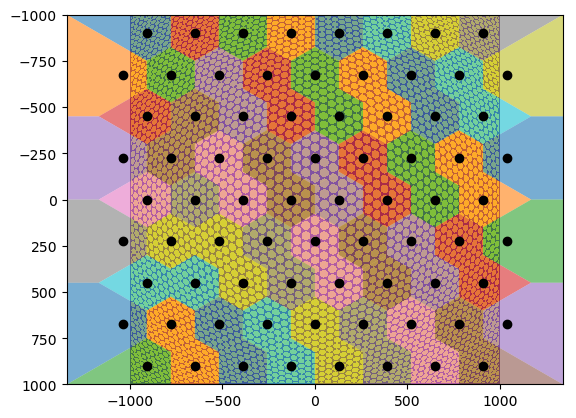

In [35]:
# STEP 4: Make voronoi tesselation
regions, vertices = TipSlicer.makeVoronoiPolygons(hexPos)
#ffOpt=FormulaSlicer.getInfillRatio(regions,vertices,T,X,Y)

# and display it
clf()
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.6)

plt.plot(hexPos[:,0], hexPos[:,1], 'ko')
plt.axis('equal')
#plt.xlim(vor.min_bound[0] - 20, vor.max_bound[0] + 20)
#plt.ylim(vor.min_bound[1] - 20, vor.max_bound[1] + 20)

plt.imshow(T,alpha=0.8,extent=(X.min(),X.max(),Y.max(),Y.min()))
display(gcf())

In [36]:
%%%time
# now find optimal solution with CONCORDE and CPLEX
pp=hexPos
TipSlicer.writeTSPfile('blocks.tsp',pp)
!concorde -o 'tsp.sol' 'blocks.tsp'
Ord=TipSlicer.readTSPfile('tsp.sol')

concorde -o tsp.sol blocks.tsp
Host: lapsam  Current process id: 23939
Using random seed 1505152141
Problem Name: blocks
Problem Type: TSP
Nanoscribe Blocks in Ham Path
Number of Nodes: 77
Explicit Lengths (CC_MATRIXNORM)
Set initial upperbound to 20185 (from tour)
  LP Value  1: 20185.000000  (0.00 seconds)
New lower bound: 20185.000000
Final lower bound 20185.000000, upper bound 20185.000000
Exact lower bound: 20185.000000
DIFF: 0.000000
Final LP has 77 rows, 117 columns, 234 nonzeros
Optimal Solution: 20185.00
Number of bbnodes: 1
Total Running Time: 0.04 (seconds)
CPU times: user 15.2 ms, sys: 17.2 ms, total: 32.4 ms
Wall time: 264 ms


In [41]:
#%%%time
# STEP 5: Write out stacks
FovZ=45
Fov=300
hatching=0.5
slicing=3

amShells=2
ScaffStep=2 # for solid infill => 2*hatching is spacing here
hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False
#CodeSpeeds=np.ones(3)*30000
#CodeIntensities=np.ones(3)*80


am=np.int(np.round(Fov/hatching))
#amY=np.int(np.round(FovY/hatching))
zz=np.arange(0,FovZ,slicing)


dirName='MicroLensesHexagonal'
if (not os.path.exists(dirName)):
    os.mkdir(dirName)
genBlockName=dirName+'/'+dirName+'Block-{:05d}.h5'
genGwlName=dirName+'/'+dirName+'Block-{:05d}.gwl'
genRegex=dirName+'/.+gwl'
fullGwlName=dirName+'.gwl'

for i in np.arange(len(Ord)):
#for i in np.arange(10):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    xc=hexPos[Ord[i],0]
    yc=hexPos[Ord[i],1]
    polygon = vertices[regions[Ord[i]]]

    xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
    yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
    Xloc,Yloc=np.meshgrid(xx,yy)
    
    MM=TipSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
    # if you need overlap, do binary_dilation on the mask
    MM=im.binary_dilation(MM,iterations=2)
    
    # with these coordinate systems, apply formulaToStack
    blockName=genBlockName.format(i)
    
    # make a formula for formulaToStack for SERPENTIN!!!
    TipSlicer.formulaToStack(blockName,Xloc,Yloc,zz,myFigure,extraParams=0,writingMask=MM)
    
    # and write the GWL's
    dists=TipSlicer.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep
                                   ,atAngles=-1,writeHeader=False,writeColourH5=False,doTopBottom=True)
    
TipSlicer.writeGwlForRegex(fullGwlName,genRegex)#,CodeSpeeds,CodeIntensities)

Writing block 0
Writing block 1
Writing block 2
Writing block 3
Writing block 4
Writing block 5
Writing block 6
Writing block 7
Writing block 8
Writing block 9
Writing block 10
Writing block 11
Writing block 12
Writing block 13
Writing block 14
Writing block 15
Writing block 16
Writing block 17
Writing block 18
Writing block 19
Writing block 20
Writing block 21
Writing block 22
Writing block 23
Writing block 24
Writing block 25
Writing block 26
Writing block 27
Writing block 28
Writing block 29
Writing block 30
Writing block 31
Writing block 32
Writing block 33
Writing block 34
Writing block 35
Writing block 36
Writing block 37
Writing block 38
Writing block 39
Writing block 40
Writing block 41
Writing block 42
Writing block 43
Writing block 44
Writing block 45
Writing block 46
Writing block 47
Writing block 48
Writing block 49
Writing block 50
Writing block 51
Writing block 52
Writing block 53
Writing block 54
Writing block 55
Writing block 56
Writing block 57
Writing block 58
Writing

NameError: name 'CodeSpeeds' is not defined

In [42]:
TipSlicer.writeGwlForRegex(fullGwlName,genRegex)

In [ ]:
# Try to calculate amount of stitched lenses